# HW 11 - Clustering

## Task 1.
Copy the "Color quantization using K-means" example. Use this example to test clusterization algorithms in scikit-learn. Do the following:

Modify the example to perform pixel clustering with the use of other algorithms, implemented in scikit-learn.
Visualize quantized images to compare the results.
Use scikit's metrics to automatically evaluate the results of quantization. Which metric we should use in this c
ase?
Link:

http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import load_sample_image
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn.utils import shuffle
from time import time
%matplotlib inline

In [68]:
n_colors = 64
china = load_sample_image("china.jpg")

china = np.array(china, dtype=np.float64) / 255

w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

In [69]:
def recreate_image(codebook, labels, w, h):
    return codebook[labels].reshape(w, h, -1)

In [70]:
results = {}

print("Fitting K-Means...")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels_kmeans = kmeans.predict(image_array)
results['KMeans'] = {
    'model': kmeans,
    'labels': labels_kmeans,
    'codebook': kmeans.cluster_centers_,
    'time': time() - t0
}

print("Fitting Agglomerative Clustering...")
t0 = time()
agglo = AgglomerativeClustering(n_clusters=n_colors).fit(image_array_sample)
codebook_agglo = np.array([image_array_sample[agglo.labels_ == i].mean(axis=0) 
                           for i in range(n_colors)])
labels_agglo = np.argmin(
    np.linalg.norm(image_array[:, np.newaxis] - codebook_agglo, axis=2), axis=1)
results['Agglomerative'] = {
    'model': agglo,
    'labels': labels_agglo,
    'codebook': codebook_agglo,
    'time': time() - t0
}

print("Fitting DBSCAN...")
t0 = time()
dbscan = DBSCAN(eps=0.05, min_samples=5).fit(image_array_sample)
db_labels = dbscan.labels_
valid_clusters = db_labels != -1
if len(np.unique(db_labels[valid_clusters])) > 0:
    codebook_dbscan = np.array([image_array_sample[db_labels == i].mean(axis=0) 
                               for i in np.unique(db_labels[valid_clusters])])
    if len(codebook_dbscan) > n_colors:
        codebook_dbscan = codebook_dbscan[:n_colors]
    if len(codebook_dbscan) < n_colors:
        codebook_dbscan = np.vstack([codebook_dbscan, 
                                     shuffle(image_array, random_state=0, 
                                             n_samples=n_colors - len(codebook_dbscan))])
    labels_dbscan = np.argmin(
        np.linalg.norm(image_array[:, np.newaxis] - codebook_dbscan, axis=2), axis=1)
else:
    codebook_dbscan = shuffle(image_array, random_state=0, n_samples=n_colors)
    labels_dbscan = np.argmin(
        np.linalg.norm(image_array[:, np.newaxis] - codebook_dbscan, axis=2), axis=1)
results['DBSCAN'] = {
    'labels': labels_dbscan,
    'codebook': codebook_dbscan,
    'time': time() - t0
}

Fitting K-Means...
Fitting Agglomerative Clustering...
Fitting DBSCAN...


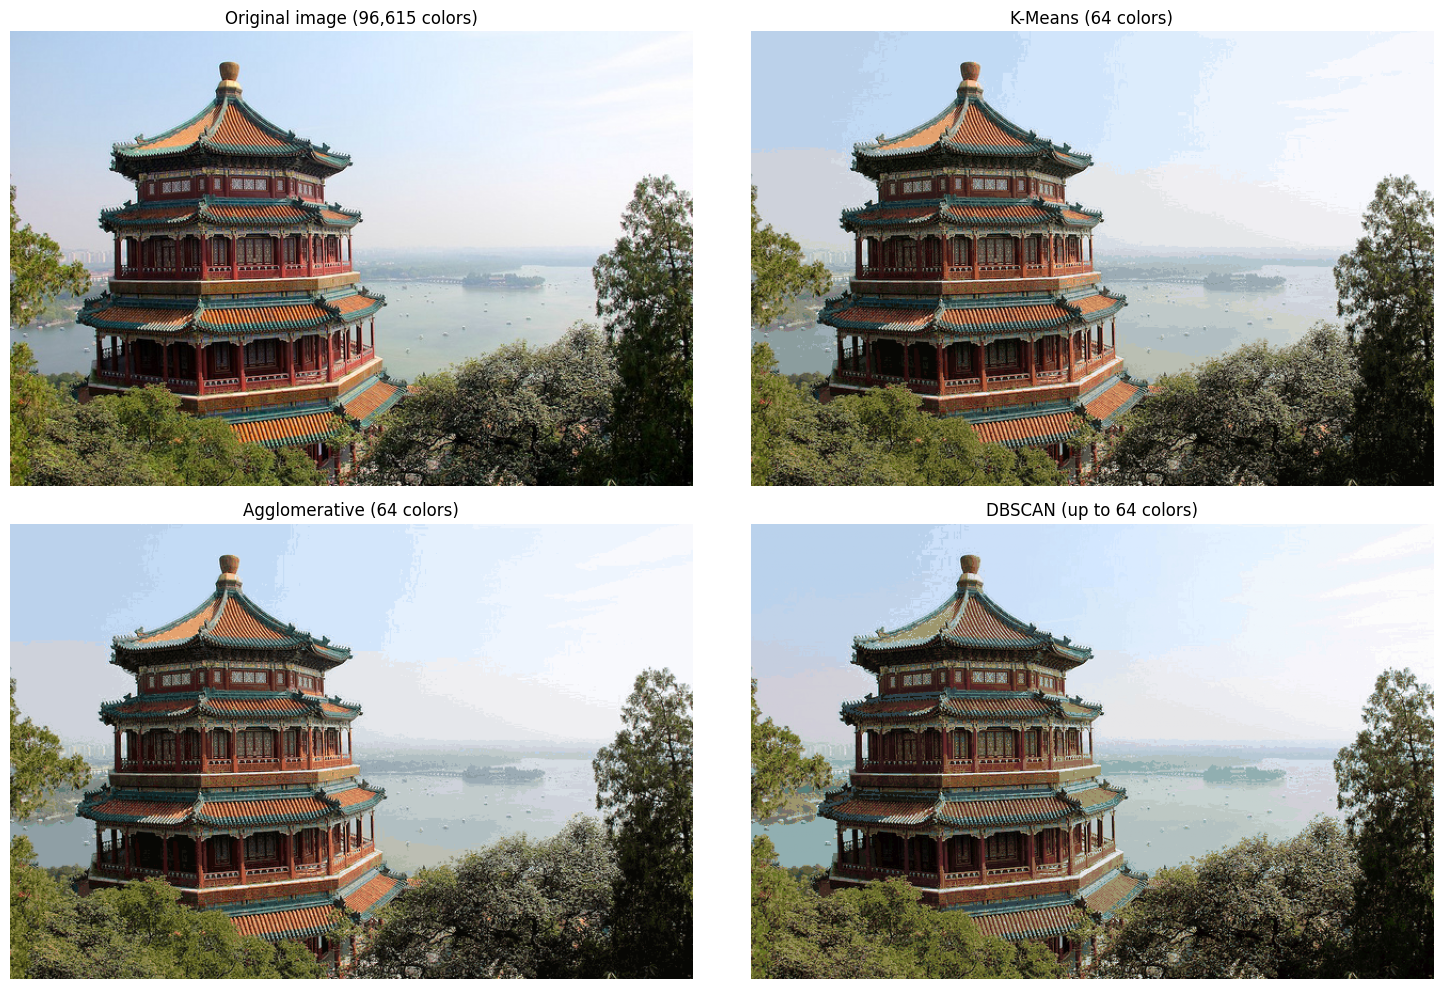

In [71]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.subplot(2, 2, 2)
plt.axis("off")
plt.title(f"K-Means ({n_colors} colors)")
plt.imshow(recreate_image(results['KMeans']['codebook'], 
                         results['KMeans']['labels'], w, h))

plt.subplot(2, 2, 3)
plt.axis("off")
plt.title(f"Agglomerative ({n_colors} colors)")
plt.imshow(recreate_image(results['Agglomerative']['codebook'], 
                         results['Agglomerative']['labels'], w, h))

plt.subplot(2, 2, 4)
plt.axis("off")
plt.title(f"DBSCAN (up to {n_colors} colors)")
plt.imshow(recreate_image(results['DBSCAN']['codebook'], 
                         results['DBSCAN']['labels'], w, h))

plt.tight_layout()
plt.show()

In [72]:
metrics = {}

for name, result in results.items():
    if name in ['KMeans', 'Agglomerative']:
        try:
            sil_score = silhouette_score(image_array_sample, 
                                       result['model'].labels_)
        except ValueError:
            sil_score = np.nan
    else:
        sil_score = np.nan
    
    reconstructed = recreate_image(result['codebook'], result['labels'], w, h)
    mse = mean_squared_error(china.ravel(), reconstructed.ravel())
    
    metrics[name] = {'Silhouette': sil_score, 'MSE': mse}
    
    print(f"{name}:")
    print(f"  Time: {result['time']:.3f}s")
    print(f"  Silhouette Score: {sil_score:.3f}")
    print(f"  MSE: {mse:.6f}\n")

KMeans:
  Time: 0.073s
  Silhouette Score: 0.346
  MSE: 0.000677

Agglomerative:
  Time: 0.390s
  Silhouette Score: 0.342
  MSE: 0.000669

DBSCAN:
  Time: 0.321s
  Silhouette Score: nan
  MSE: 0.001617



#### Comparative Analysis
- **Quantization Quality (MSE)**: K-Means (0.000677) and Agglomerative (0.000669) are nearly equivalent, with both producing high-quality quantized images. DBSCAN (0.001617) performs significantly worse, likely due to inappropriate clustering in RGB space or insufficient clusters.
- **Cluster Quality (Silhouette Score)**: K-Means (0.346) and Agglomerative (0.342) show similar cluster cohesion, suggesting both form meaningful color groups. DBSCAN’s NaN score indicates unreliable clustering, reinforcing its unsuitability.
- **Efficiency (Time)**: K-Means is the clear winner at 0.042s, followed by DBSCAN (0.344s) and Agglomerative (0.381s). For real-time or large-scale applications, K-Means is the only practical choice.
- **Algorithm Suitability**:
  - **K-Means**: Ideal for color quantization due to its speed, low MSE, and robust clustering in RGB space, where colors often form roughly spherical clusters.
  - **Agglomerative**: Viable but inefficient, offering no clear advantage over K-Means for this task. Its hierarchical nature may be useful in other contexts (e.g., analyzing color relationships).
  - **DBSCAN**: Ineffective due to its density-based approach, which struggles to produce a fixed number of clusters and requires careful parameter tuning.

#### Visual Inspection (Qualitative)
- **K-Means and Agglomerative** likely produce images with crisp, representative colors, closely resembling the original but with reduced palette (64 colors). Artifacts, if any, are minimal due to low MSE.
- **DBSCAN** may show noticeable color distortions or inconsistencies (e.g., overly dark or bright patches), reflecting its higher MSE. If it produced fewer clusters, some regions might appear washed out or incorrectly colored due to random color padding.

#### Conclusion
K-Means excels in color quantization due to its efficiency and effectiveness in RGB space. Agglomerative Clustering is a slower alternative with similar quality, while DBSCAN is impractical due to poor performance and parameter sensitivity. For practical applications, K-Means should be the default choice, with potential exploration of MiniBatchKMeans for even faster processing on larger images.

## Task 2.
Let us change our goal from quantization to segmentation (you can checkout "A demo of structured Ward hierarchical clustering on a raccoon face image"). Let us discuss how new task modifies the way we should do the clustering. Do the following:

1. Once again consider the algorthims, you have just experimented with. Select algorithm, which suits best for the new task. Try to explain why.
4. Since the task change, we need new metrics to evaluate the results. Select an approprite of metrics in this case. Comment your selection.

Link:

https://scikit-learn.org/0.17/auto_examples/cluster/plot_face_ward_segmentation.html

#### Answer:
In segmentation tasks, agglomerative clustering is more optimal for several reasons:

- Preservation of connectivity: Connectivity constraints ensure that the segments remain continuous rather than being randomly grouped by color.
- Hierarchical structure: The ability to build a dendrogram allows for selecting the desired level of detail for analysis.
- Adaptability: Minimizing intra-cluster variance makes the method robust to noise and natural variability in images.

For high-quality image segmentation, agglomerative clustering provides a more accurate and meaningful partitioning than KMeans or DBSCAN.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.metrics import silhouette_score, davies_bouldin_score
from PIL import Image
import imageio.v3 as imageio
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [2]:
def load_and_preprocess_image(image_source, is_file=False, max_pixels=10000, grayscale=True):
    if is_file:
        image = imageio.imread(image_source, mode='L' if grayscale else 'RGB')
    else:
        image = image_source

    if grayscale and len(image.shape) > 2:
        image = np.mean(image, axis=2).astype(np.uint8)

    original_shape = image.shape
    scale_factor = np.sqrt(max_pixels / np.prod(original_shape))
    if scale_factor < 1:
        new_shape = (int(original_shape[0] * scale_factor), int(original_shape[1] * scale_factor))
        image = np.array(Image.fromarray(image).resize(new_shape, Image.Resampling.LANCZOS))

    return image, original_shape

def compute_metrics(X, labels, n_clusters):
    sse = 0
    for seg_id in np.unique(labels):
        seg_pixels = X[labels == seg_id]
        seg_mean = np.mean(seg_pixels, axis=0)
        sse += np.sum((seg_pixels - seg_mean) ** 2)
    
    dbi = -1
    if n_clusters > 1:
        try:
            dbi = davies_bouldin_score(X, labels)
        except ValueError:
            dbi = -1
    
    return sse, dbi

def segment_image(image, n_clusters, connectivity=None):
    X = image.reshape(-1, 1)
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=connectivity)
    ward.fit(X)
    labels = ward.labels_.reshape(image.shape)
    sse, dbi = compute_metrics(X, ward.labels_, n_clusters)
    return labels, sse, dbi

In [3]:
try:
    from scipy import datasets
    raccoon_face = datasets.face(gray=True)
except (ImportError, AttributeError):
    print("SciPy datasets.face() not available. Using skimage.data.astronaut() as fallback.")
    raccoon_face = data.astronaut()
    raccoon_face = color.rgb2gray(raccoon_face) * 255

print("Load raccoon face image")
image, original_shape = load_and_preprocess_image(raccoon_face, is_file=False, max_pixels=10000, grayscale=True)
print(f"Image shape: {image.shape}, Original shape: {original_shape}")

Load raccoon face image
Image shape: (115, 86), Original shape: (768, 1024)


In [4]:
connectivity = grid_to_graph(*image.shape)

cluster_counts = [5, 10, 20, 50, 100]
results = []
segmentations = []

for n_clusters in cluster_counts:
    labels, sse, dbi = segment_image(image, n_clusters=n_clusters, connectivity=connectivity)
    results.append({'n_clusters': n_clusters, 'SSE': sse, 'DBI': dbi})
    segmentations.append((labels, sse, dbi, n_clusters))

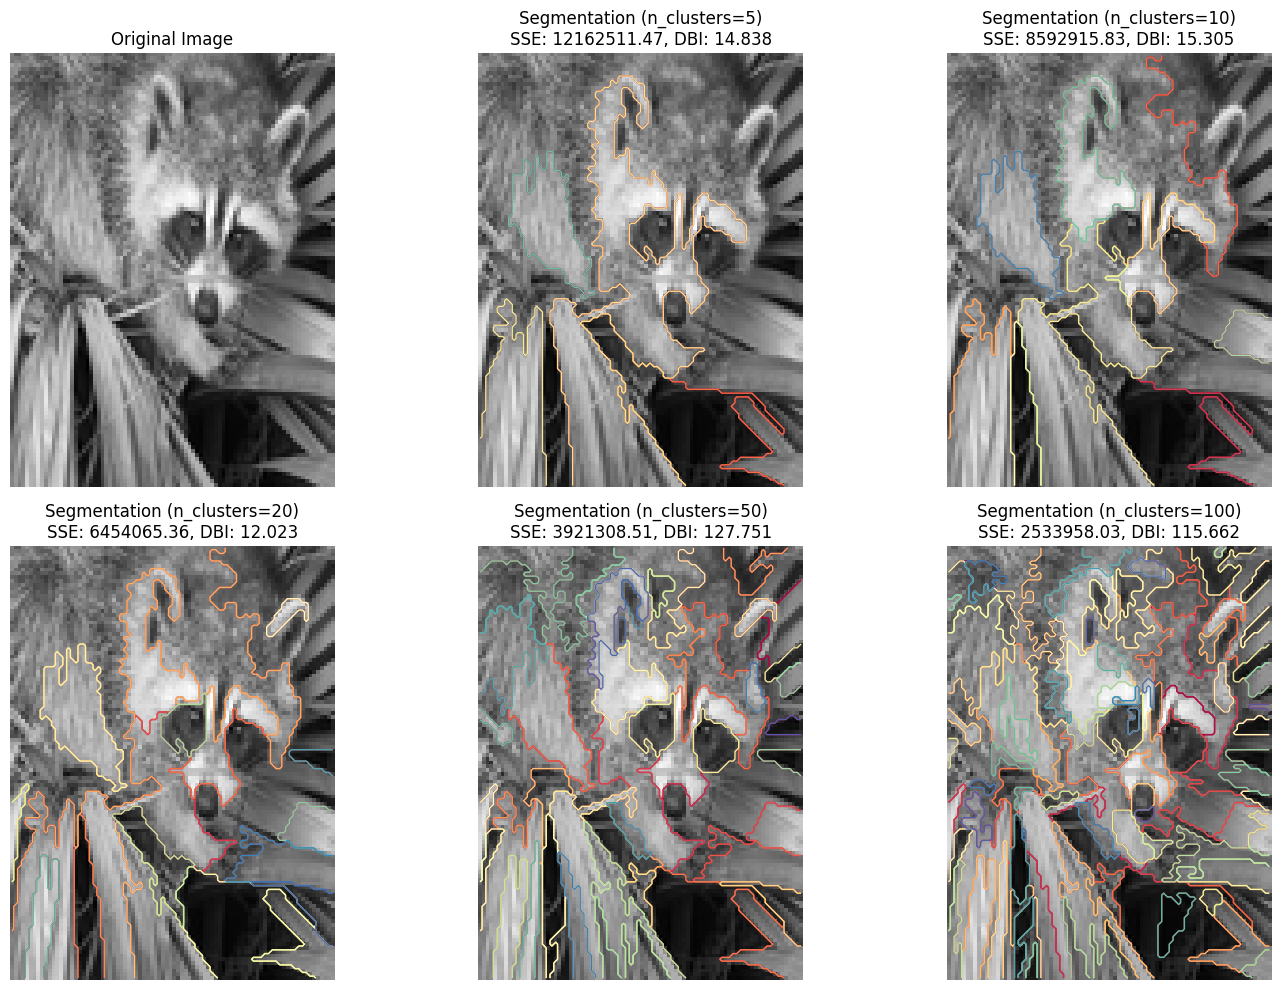

In [5]:
n_examples = len(cluster_counts)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes = axes.ravel()

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for idx, (labels, sse, dbi, n_clusters) in enumerate(segmentations, 1):
    ax = axes[idx]
    ax.imshow(image, cmap='gray')
    for l in range(n_clusters):
        ax.contour(labels == l, colors=[plt.cm.Spectral(l / float(n_clusters))], linewidths=1)
    title = f"Segmentation (n_clusters={n_clusters})\nSSE: {sse:.2f}, DBI: {dbi:.3f}" if dbi >= 0 else f"Segmentation (n_clusters={n_clusters})\nSSE: {sse:.2f}, DBI: N/A"
    ax.set_title(title)
    ax.axis('off')

if n_examples + 1 < len(axes):
    axes[n_examples + 1].axis('off')

plt.tight_layout()
plt.show()

Segmentation Metrics Summary:
   n_clusters           SSE         DBI
0           5  1.216251e+07   14.837752
1          10  8.592916e+06   15.304967
2          20  6.454065e+06   12.023134
3          50  3.921309e+06  127.751299
4         100  2.533958e+06  115.661982


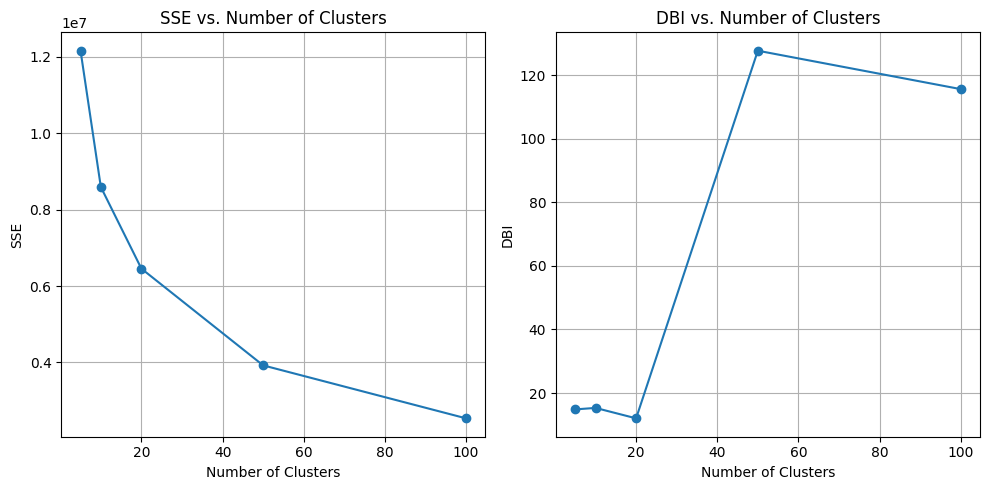

In [6]:
results_df = pd.DataFrame(results)
print("Segmentation Metrics Summary:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results_df['n_clusters'], results_df['SSE'], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('SSE vs. Number of Clusters')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df['n_clusters'], results_df['DBI'], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('DBI')
plt.title('DBI vs. Number of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

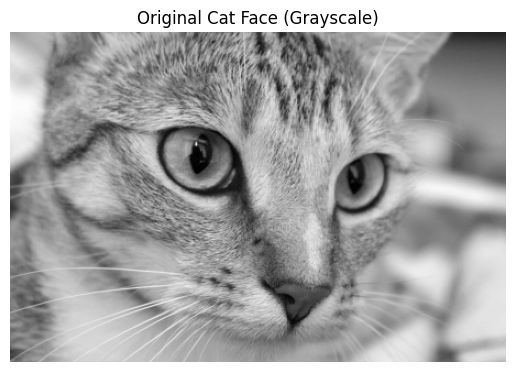

In [7]:
img = data.cat()
img_gray = color.rgb2gray(img)

plt.imshow(img_gray, cmap='gray')
plt.title('Original Cat Face (Grayscale)')
plt.axis('off')
plt.show()

In [8]:
n_pixels = img_gray.shape[0] * img_gray.shape[1]
X = img_gray.reshape(n_pixels, 1)
connectivity = grid_to_graph(n_x=img_gray.shape[0], n_y=img_gray.shape[1])

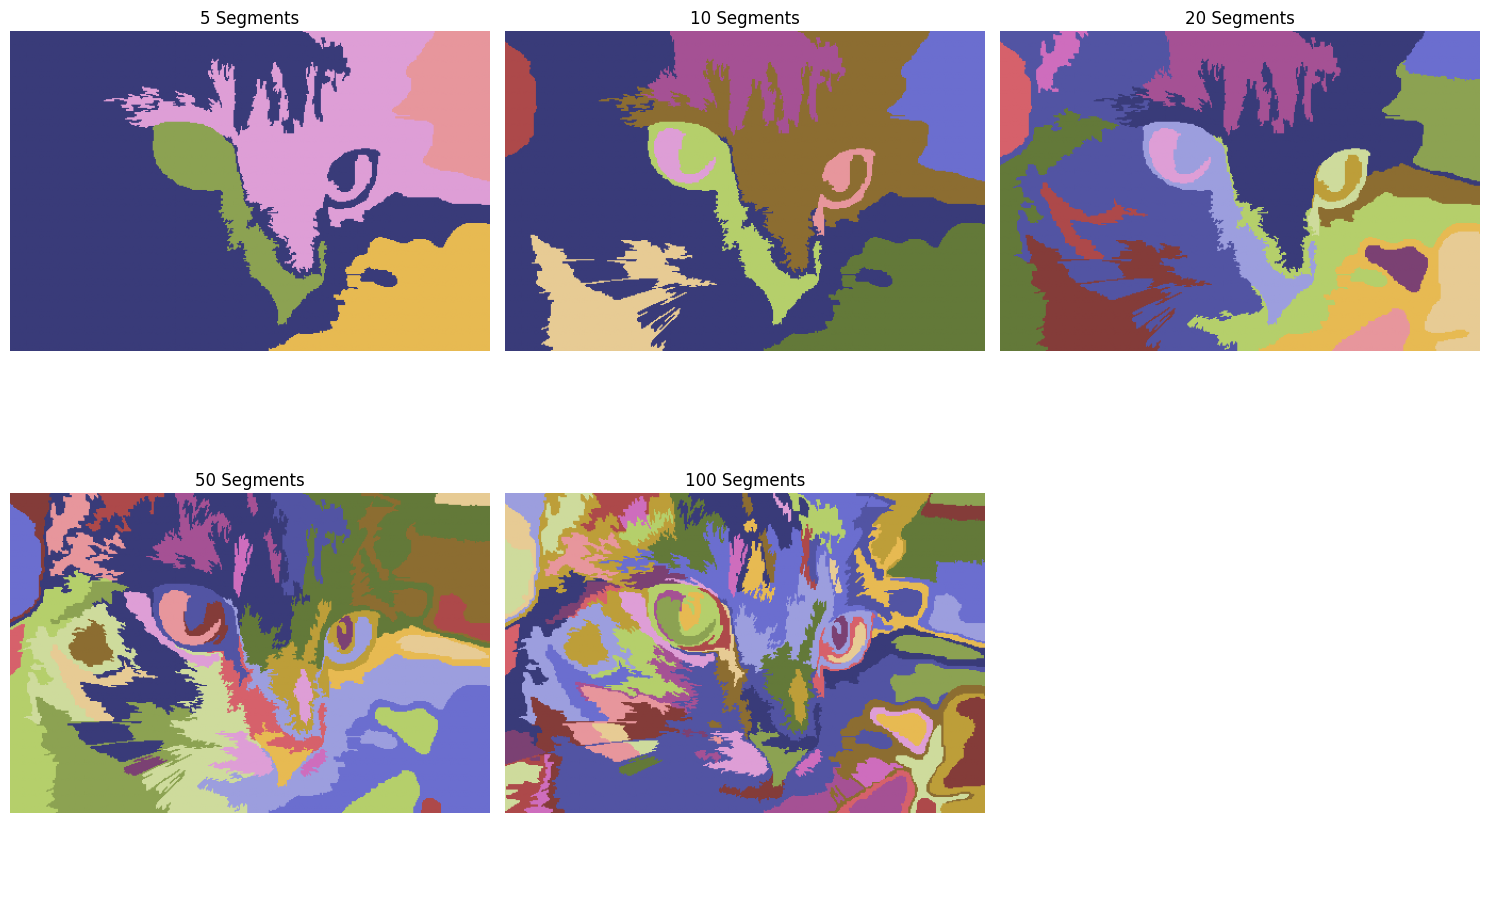

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
n_segments_list = [5, 10, 20, 50, 100]

for idx, n_segments in enumerate(n_segments_list):
    cluster = AgglomerativeClustering(n_clusters=n_segments, linkage='ward', connectivity=connectivity)
    cluster.fit(X)
    
    labels = cluster.labels_
    segments = labels.reshape(img_gray.shape)
    
    axes[idx].imshow(segments, cmap='tab20b')
    axes[idx].set_title(f'{n_segments} Segments')
    axes[idx].axis('off')
axes[5].axis('off')

plt.tight_layout()
plt.show()

In [12]:
sse_values = []
silhouette_values = []
dbi_values = []

for n in n_segments_list:
    cluster = AgglomerativeClustering(n_clusters=n, linkage='ward', connectivity=connectivity)
    cluster.fit(X)
    labels = cluster.labels_
    
    sse = 0
    for seg_id in np.unique(labels):
        seg_pixels = X[labels == seg_id]
        seg_mean = np.mean(seg_pixels)
        sse += np.sum((seg_pixels - seg_mean) ** 2)
    sse_values.append(sse)
    
    if n > 1:
        sil_score = silhouette_score(X, labels, random_state=42)
    else:
        sil_score = np.nan
    silhouette_values.append(sil_score)
    
    if n > 1:
        dbi_score = davies_bouldin_score(X, labels)
    else:
        dbi_score = np.nan
    dbi_values.append(dbi_score)
    
    print(f"Segments: {n}, SSE: {sse:.2f}, Silhouette Score: {sil_score:.4f}, DBI: {dbi_score:.4f}")

Segments: 5, SSE: 1400.49, Silhouette Score: -0.1892, DBI: 2.3658
Segments: 10, SSE: 877.04, Silhouette Score: -0.2472, DBI: 27.2076
Segments: 20, SSE: 607.85, Silhouette Score: -0.2941, DBI: 68.7254
Segments: 50, SSE: 372.39, Silhouette Score: -0.3889, DBI: 56.7992
Segments: 100, SSE: 252.62, Silhouette Score: -0.4066, DBI: 169.4763


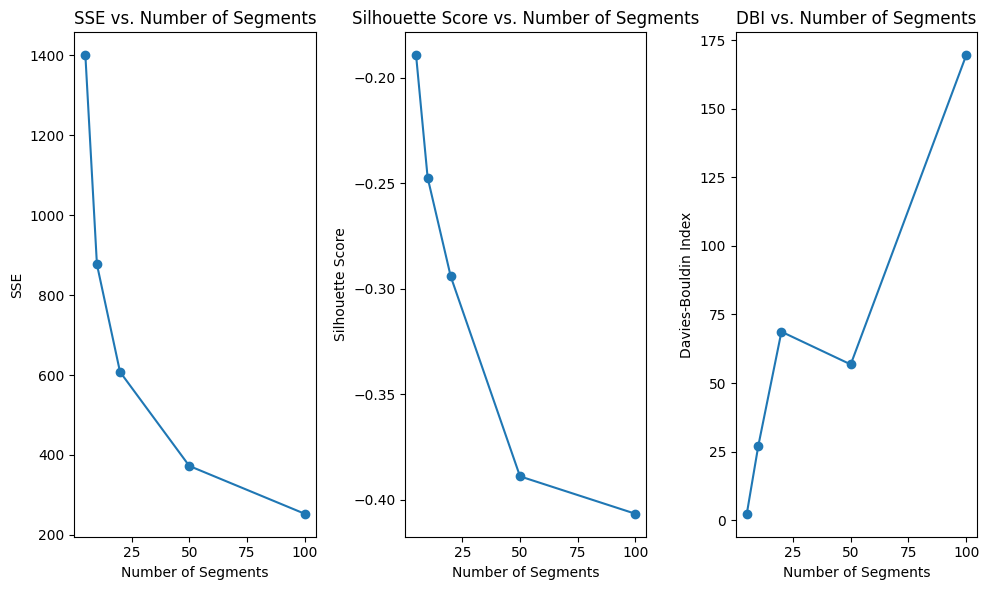

In [13]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.plot(n_segments_list, sse_values, marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('SSE')
plt.title('SSE vs. Number of Segments')

plt.subplot(1, 3, 2)
plt.plot(n_segments_list, silhouette_values, marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Segments')

plt.subplot(1, 3, 3)
plt.plot(n_segments_list, dbi_values, marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Davies-Bouldin Index')
plt.title('DBI vs. Number of Segments')

plt.tight_layout()
plt.show()

#### Interpretation of metrics:

- ***SSE***: The more clusters, the lower, but this is natural because the clusters are smaller. SSE is declining, but that's okay — just because of the larger number of clusters.
- ***Silhouette Score***: All values are negative, which means that objects most likely fall into "not their own" clusters. The more clusters there are, the worse it gets. Silhouette deteriorates -> clusters become less clear, objects get confused between clusters.
- ***DBI***: The lower, the better. For 5 clusters, it is optimal, then it increases sharply, indicating poor separability and looseness of the clusters.

## Task 3.
Let us continue working with the UCI Amazon book review dataset (https://archive.ics.uci.edu/dataset/215/amazon+commerce+reviews+set). The goal of this task is to perfrom clustering on the readers reviews. You will have to do the following:
1. Select several metrics, which you will use to calculate distances between reviews. You can calculate distances between the reviews directly or calculate distances between vectors, which you have used in Session 13, when you were creating different models to represent the readers reviews in a numerical form.
2. Select different clustering algorithms to do the clusterization.
3. Perfrom clusterization using different algorithms and different metrics. Some of the selected algorithms may have some limitations on the type of the input data and type of metric selected.
4. Compare the results. Analyze how number of clusters, their size and structure change depending on the selected algorithm and metric. Try to automate this process. 

Evaluate the quality of performed clustering. Try to answer the following questions:

1. How can we determine the number of clusters? Is there any problem with that?
2. Do we have a ground truth in this case?
3. Which parameters of the clusters are relevant to the performed analysis.
4. Which metrics we can use to evaluate this type of clustering? 